In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
# Class imbalance handling
# For example, you could use techniques like oversampling or undersampling
# Here's a hypothetical example using RandomOverSampler from imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# loading the dataset
netflix = pd.read_csv('/content/netflix_titles.csv.zip')
netflix

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [ ]:
# Check for missing values
print("Missing values before handling:")
print(netflix.isnull().sum())

Missing values before handling:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [ ]:
# Drop rows with missing values
netflix.dropna(inplace=True)
# Reset index after dropping rows
netflix.reset_index(drop=True, inplace=True)
# Edit the date_added column
netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce', infer_datetime_format=True)

<ipython-input-6-6bb28669fd00>:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce', infer_datetime_format=True)


In [ ]:
# show the dataset info after dropping the duplicates
netflix.info()
netflix.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5332 entries, 0 to 5331
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       5332 non-null   object        
 1   type          5332 non-null   object        
 2   title         5332 non-null   object        
 3   director      5332 non-null   object        
 4   cast          5332 non-null   object        
 5   country       5332 non-null   object        
 6   date_added    5328 non-null   datetime64[ns]
 7   release_year  5332 non-null   int64         
 8   rating        5332 non-null   object        
 9   duration      5332 non-null   object        
 10  listed_in     5332 non-null   object        
 11  description   5332 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 500.0+ KB


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
1,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,2021-09-24,2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
2,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
3,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",2021-09-23,2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...
4,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,2021-09-21,1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...
...,...,...,...,...,...,...,...,...,...,...,...,...
5327,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan",2016-03-09,2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...
5328,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
5329,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
5330,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [ ]:
# edit the date_added column
netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce')

In [ ]:
# show the dataset info after editting the date_added column
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5332 entries, 0 to 5331
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       5332 non-null   object        
 1   type          5332 non-null   object        
 2   title         5332 non-null   object        
 3   director      5332 non-null   object        
 4   cast          5332 non-null   object        
 5   country       5332 non-null   object        
 6   date_added    5328 non-null   datetime64[ns]
 7   release_year  5332 non-null   int64         
 8   rating        5332 non-null   object        
 9   duration      5332 non-null   object        
 10  listed_in     5332 non-null   object        
 11  description   5332 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 500.0+ KB


In [ ]:
# type column
types = netflix['type'].value_counts().reset_index()
types

,type,count
0,Movie,5185
1,TV Show,147


In [ ]:
#director column
directors = netflix['director'].value_counts().reset_index()
directors

,director,count
0,"Raúl Campos, Jan Suter",18
1,Marcus Raboy,15
2,Jay Karas,14
3,Cathy Garcia-Molina,13
4,Martin Scorsese,12
...,...,...
3940,"Igor Kovalyov, Norton Virgien",1
3941,Danny Cannon,1
3942,Mana Yasuda,1
3943,Gupse Özay,1


In [ ]:
#director and type columns
directors = netflix.groupby(['director', 'type'])['director'].value_counts().reset_index()
directors

,director,type,count
0,A. L. Vijay,Movie,2
1,A. Raajdheep,Movie,1
2,A. Salaam,Movie,1
3,A.R. Murugadoss,Movie,1
4,Aadish Keluskar,Movie,1
...,...,...,...
3964,Çagan Irmak,Movie,1
3965,Ísold Uggadóttir,Movie,1
3966,Óskar Thór Axelsson,Movie,1
3967,Ömer Faruk Sorak,Movie,2


In [ ]:
#top 10 directors
top_10_directors = netflix.groupby(['director', 'type'])['director'].value_counts().sort_values(ascending=False).iloc[2:12]
top_10_directors

director             type 
Marcus Raboy         Movie    14
Cathy Garcia-Molina  Movie    13
Youssef Chahine      Movie    12
Jay Chapman          Movie    12
Martin Scorsese      Movie    12
Steven Spielberg     Movie    11
Don Michael Paul     Movie    10
David Dhawan         Movie     9
Yılmaz Erdoğan       Movie     8
Troy Miller          Movie     8
Name: count, dtype: int64

In [ ]:
# country column
countries = netflix.groupby(['country', 'type'])['country'].value_counts().reset_index()

In [ ]:
# Calculate top 10 countries for both TV shows and movies
top_10_countries = netflix.groupby(['country', 'type'])['country'].value_counts().sort_values(ascending=False).iloc[0:10]

In [ ]:
# Separate the top 10 countries for TV shows and movies
top_10_TV_Show_countries = countries[countries['type'] == 'TV Show'].sort_values(by='count', ascending=False).iloc[0:10]
top_10_movie_countries = countries[countries['type'] == 'Movie'].sort_values(by='count', ascending=False).iloc[0:10]

# Print the top 10 countries for both TV shows and movies
print("Top 10 Countries for TV Shows:")
print(top_10_TV_Show_countries)

print("\nTop 10 Countries for Movies:")
print(top_10_movie_countries)

Top 10 Countries for TV Shows:
            country     type  count
521   United States  TV Show     27
439  United Kingdom  TV Show     19
372     South Korea  TV Show     10
267           Japan  TV Show     10
205           India  TV Show      7
380           Spain  TV Show      7
416          Taiwan  TV Show      7
128          France  TV Show      5
421        Thailand  TV Show      5
426          Turkey  TV Show      5

Top 10 Countries for Movies:
            country   type  count
520   United States  Movie   1819
204           India  Movie    868
438  United Kingdom  Movie    164
47           Canada  Movie    104
120           Egypt  Movie     90
379           Spain  Movie     84
308         Nigeria  Movie     84
226       Indonesia  Movie     76
425          Turkey  Movie     74
266           Japan  Movie     73


In [ ]:
# release_year column
release_years = netflix.groupby(['release_year', 'type'])['release_year'].value_counts().reset_index()

# Separate the release years for TV shows and movies
top_10_movies_years = release_years[release_years['type'] == 'Movie'].sort_values(by='count', ascending=False).iloc[0:10]
top_10_TV_show_years = release_years[release_years['type'] == 'TV Show'].sort_values(by='count', ascending=False).iloc[0:10]

# Print the top 10 release years for TV shows and movies
print("Top 10 Release Years for Movies:")
print(top_10_movies_years)

print("\nTop 10 Release Years for TV Shows:")
print(top_10_TV_show_years)

Top 10 Release Years for Movies:
    release_year   type  count
77          2017  Movie    640
79          2018  Movie    632
75          2016  Movie    567
81          2019  Movie    495
83          2020  Movie    409
73          2015  Movie    340
71          2014  Movie    234
69          2013  Movie    195
67          2012  Movie    159
85          2021  Movie    146

Top 10 Release Years for TV Shows:
    release_year     type  count
84          2020  TV Show     33
82          2019  TV Show     24
78          2017  TV Show     17
80          2018  TV Show     16
86          2021  TV Show     15
76          2016  TV Show     10
74          2015  TV Show      9
72          2014  TV Show      8
68          2012  TV Show      4
59          2006  TV Show      3


In [ ]:
# Rating column
ratings = netflix.groupby(['rating', 'type'])['type'].value_counts().reset_index()

# Calculate top 10 movie ratings
top_10_movies_ratings = ratings[(ratings['type'] == 'Movie')].sort_values(by='type', ascending=False).iloc[0:10]

# Calculate top 10 TV show ratings
top_10_TV_show_ratings = ratings[(ratings['type'] == 'TV Show')].sort_values(by='type', ascending=False).iloc[0:10]

# Print the top 10 movie ratings
print("Top 10 Movie Ratings:")
print(top_10_movies_ratings)

# Print the top 10 TV show ratings
print("\nTop 10 TV Show Ratings:")
print(top_10_TV_show_ratings)

Top 10 Movie Ratings:
   rating   type  count
0       G  Movie     40
1   NC-17  Movie      2
2      NR  Movie     58
3      PG  Movie    275
4   PG-13  Movie    470
5       R  Movie    778
6   TV-14  Movie   1177
8    TV-G  Movie     81
10  TV-MA  Movie   1741
12  TV-PG  Movie    416

Top 10 TV Show Ratings:
   rating     type  count
7   TV-14  TV Show     37
9    TV-G  TV Show      3
11  TV-MA  TV Show     81
13  TV-PG  TV Show     15
15   TV-Y  TV Show      5
17  TV-Y7  TV Show      6


In [ ]:
# Duration Column
durations = netflix.groupby(['duration', 'type'])['duration'].value_counts().reset_index()

# Top 10 movie durations
top_10_movie_durations = durations[durations['type'] == 'Movie'].sort_values(by='count', ascending=False).iloc[0:10]

# Print top 10 movie durations
print("Top 10 Movie Durations:")
print(top_10_movie_durations)

# Top 10 TV show durations
top_10_TV_Show_durations = durations[durations['type'] == 'TV Show'].sort_values(by='count', ascending=False).iloc[0:10]

# Print top 10 TV show durations
print("\nTop 10 TV Show Durations:")
print(top_10_TV_Show_durations)

Top 10 Movie Durations:
    duration   type  count
192   94 min  Movie    135
191   93 min  Movie    130
195   97 min  Movie    129
193   95 min  Movie    127
188   90 min  Movie    123
189   91 min  Movie    117
3    102 min  Movie    112
194   96 min  Movie    109
196   98 min  Movie    109
190   92 min  Movie    109

Top 10 TV Show Durations:
       duration     type  count
0      1 Season  TV Show    106
101   2 Seasons  TV Show     18
142   5 Seasons  TV Show      6
131   4 Seasons  TV Show      4
123   3 Seasons  TV Show      3
153   6 Seasons  TV Show      3
187   9 Seasons  TV Show      3
175   8 Seasons  TV Show      2
54   15 Seasons  TV Show      1
164   7 Seasons  TV Show      1


In [ ]:
# Listed_in column
listed_in = netflix.groupby(['listed_in', 'type'])['listed_in'].value_counts().reset_index()

# Top 10 listed genres for movies
top_10_listed_in_movie = listed_in[listed_in['type'] == 'Movie'].sort_values(by='count', ascending=False).iloc[0:10]

# Top 10 listed genres for TV shows
top_10_listed_in_TV_Show = listed_in[listed_in['type'] == 'TV Show'].sort_values(by='count', ascending=False).iloc[0:10]

# Print the top 10 listed genres for both movies and TV shows
print("Top 10 Listed Genres for Movies:")
print(top_10_listed_in_movie)

print("\nTop 10 Listed Genres for TV Shows:")
print(top_10_listed_in_TV_Show)

Top 10 Listed Genres for Movies:
                                            listed_in   type  count
245                      Dramas, International Movies  Movie    336
325                                   Stand-Up Comedy  Movie    286
159            Comedies, Dramas, International Movies  Movie    257
238  Dramas, Independent Movies, International Movies  Movie    243
97                 Children & Family Movies, Comedies  Movie    179
248     Dramas, International Movies, Romantic Movies  Movie    160
210                                     Documentaries  Movie    156
176                    Comedies, International Movies  Movie    152
179   Comedies, International Movies, Romantic Movies  Movie    143
228                                            Dramas  Movie    133

Top 10 Listed Genres for TV Shows:
                                             listed_in     type  count
196  Crime TV Shows, International TV Shows, TV Dramas  TV Show     17
327          Stand-Up Comedy & Talk Shows

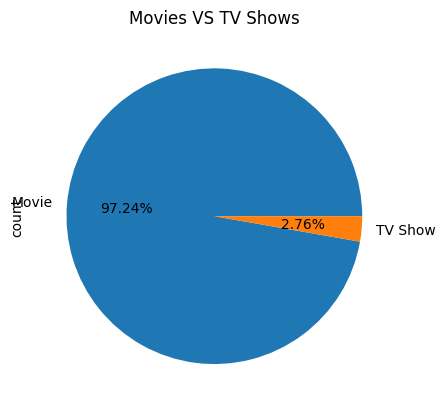

In [ ]:
# Visualizing the types of shows
types_plot = types.reset_index()  # Resetting the index to make 'type' a column again
types_plot.set_index('type', inplace=True)
types_plot.plot.pie(y='count', autopct='%.2f%%', legend=None)
plt.title("Movies VS TV Shows")
plt.show()

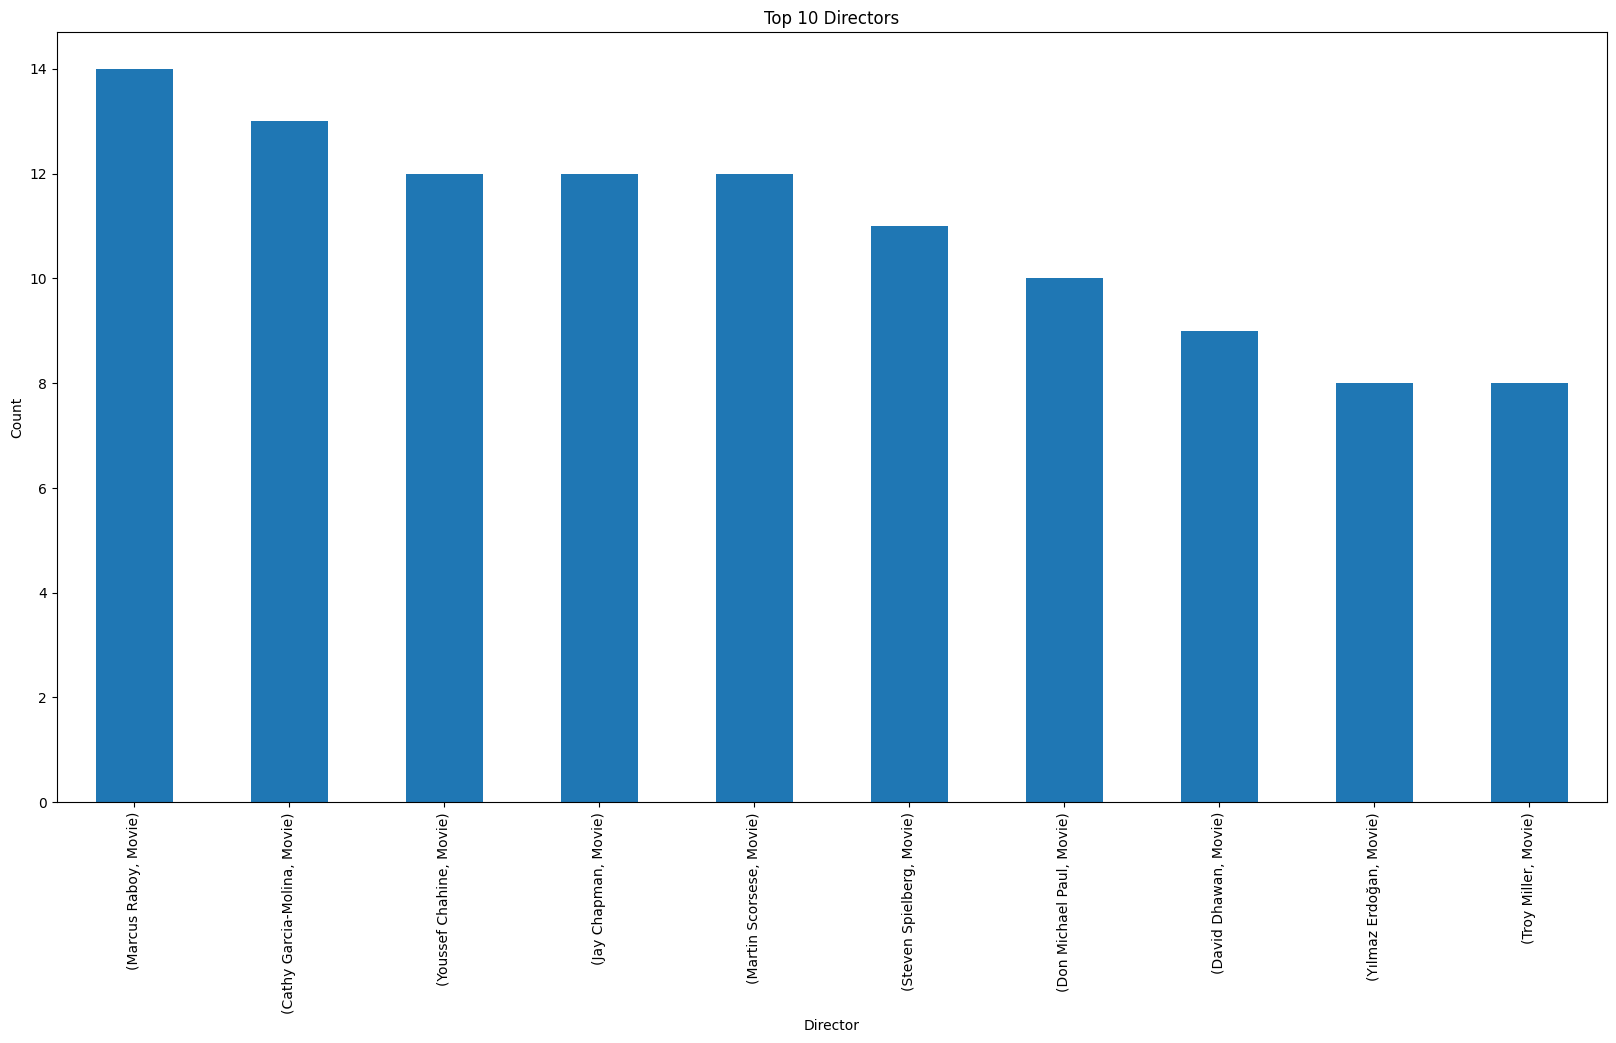

In [ ]:
#visualizing the director column
plt.figure(figsize=(20, 10))
top_10_directors.plot(x='director', y='count', kind='bar')
plt.title('Top 10 Directors')
plt.xlabel('Director')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

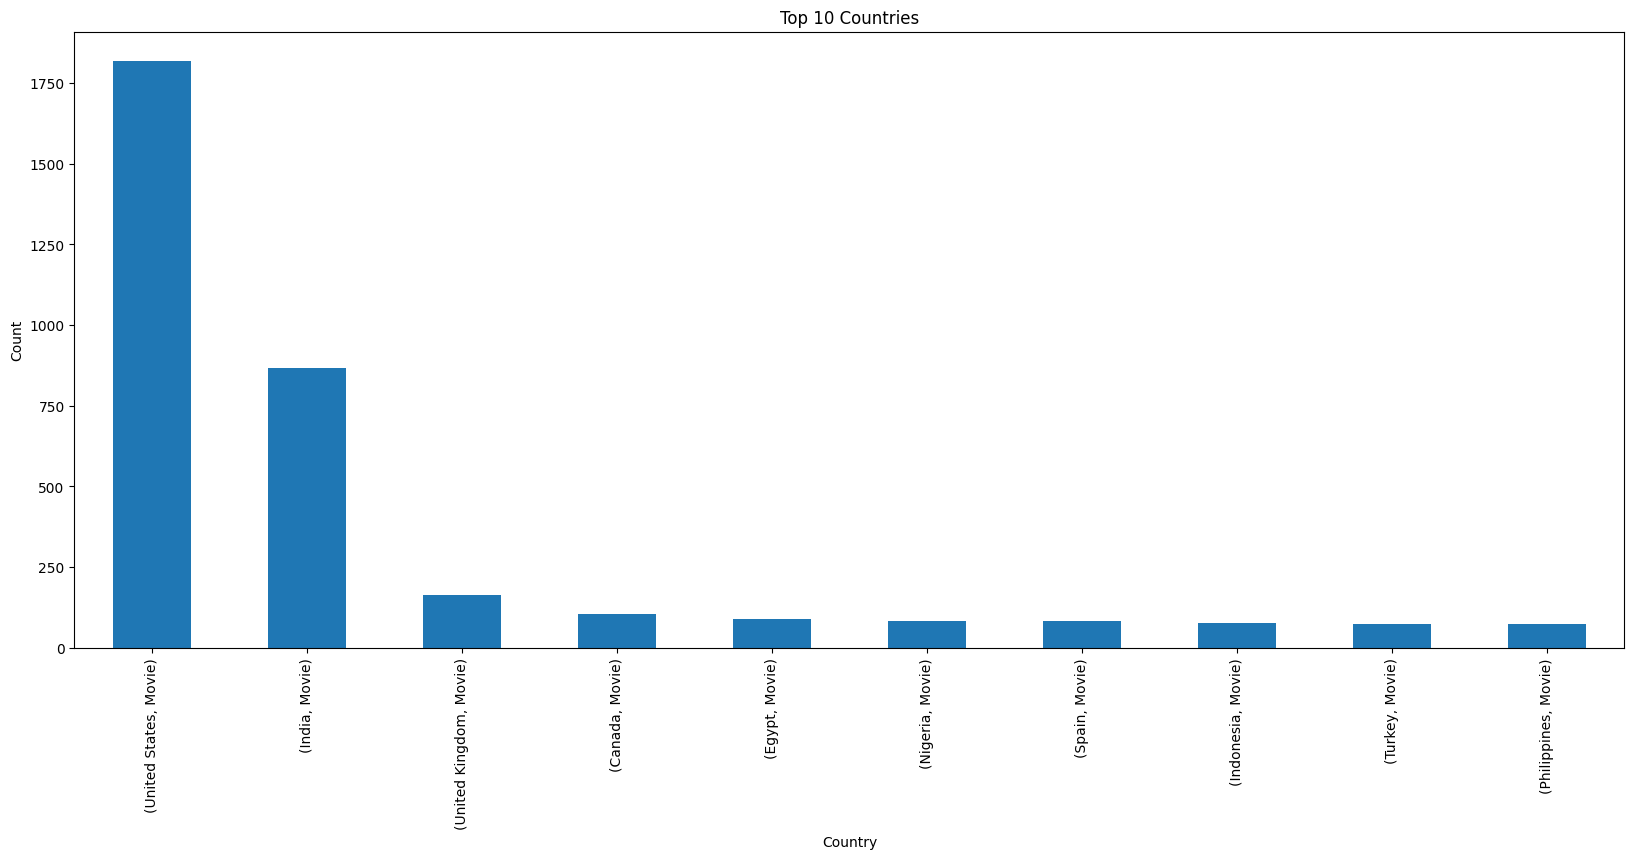

In [ ]:
#visualizing the country column
plt.figure(figsize=(20, 8))
top_10_countries.plot(x='country', y='country', kind='bar')
plt.title("Top 10 Countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

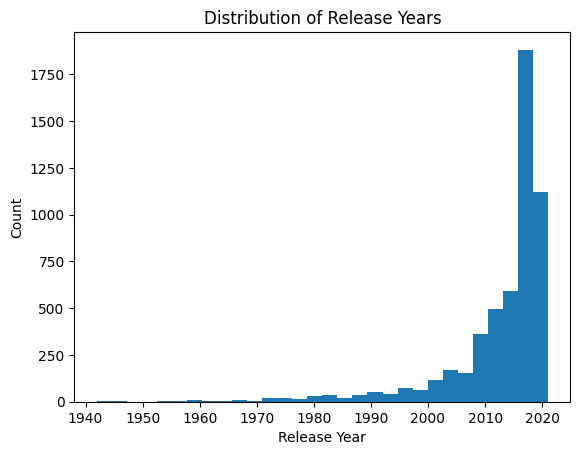

In [ ]:
# visualizing the release_year column
netflix['release_year'].plot(kind='hist', bins=30)
plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

In [ ]:
# Rating column
ratings = netflix.groupby(['rating', 'type'])['type'].value_counts().reset_index()

# Calculate top 10 movie ratings
top_10_movies_ratings = ratings[(ratings['type'] == 'Movie')].sort_values(by='type', ascending=False).iloc[0:10]

# Calculate top 10 TV show ratings
top_10_TV_show_ratings = ratings[(ratings['type'] == 'TV Show')].sort_values(by='type', ascending=False).iloc[0:10]

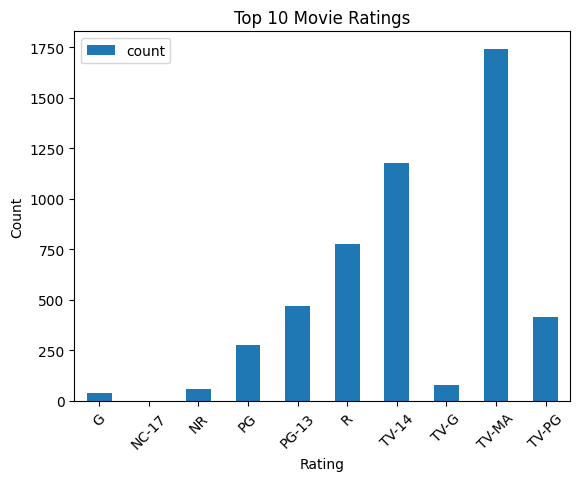

In [ ]:
# Visualize the top 10 movie ratings
top_10_movies_ratings.plot(x='rating', y='count', kind='bar')
plt.title('Top 10 Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

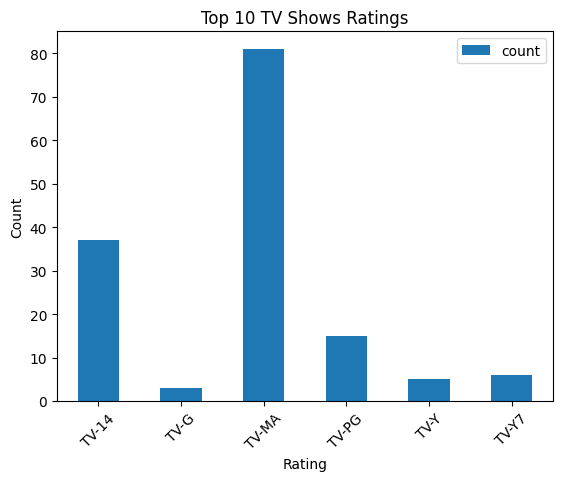

In [ ]:
# Visualize the top 10 TV show ratings
top_10_TV_show_ratings.plot(x='rating', y='count', kind='bar')
plt.title('Top 10 TV Shows Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

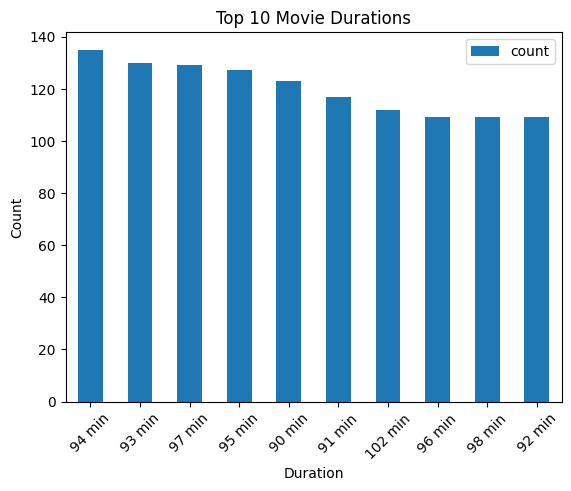

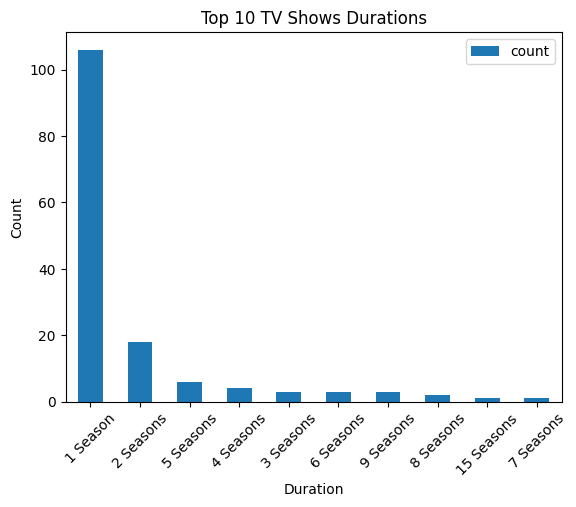

In [ ]:
# visualizing the duration column
top_10_movie_durations.plot(x='duration', y='count', kind='bar')
plt.title('Top 10 Movie Durations')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
top_10_TV_Show_durations.plot(x='duration', y='count', kind='bar')
plt.title('Top 10 TV Shows Durations')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

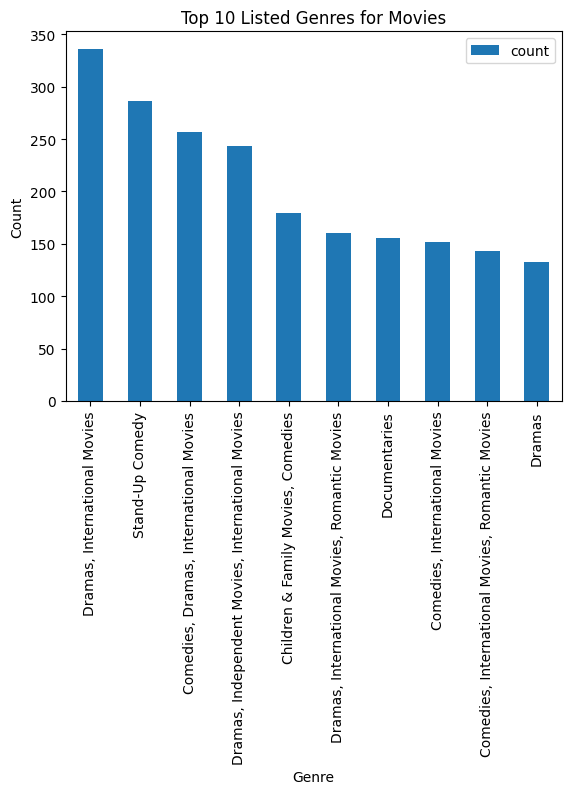

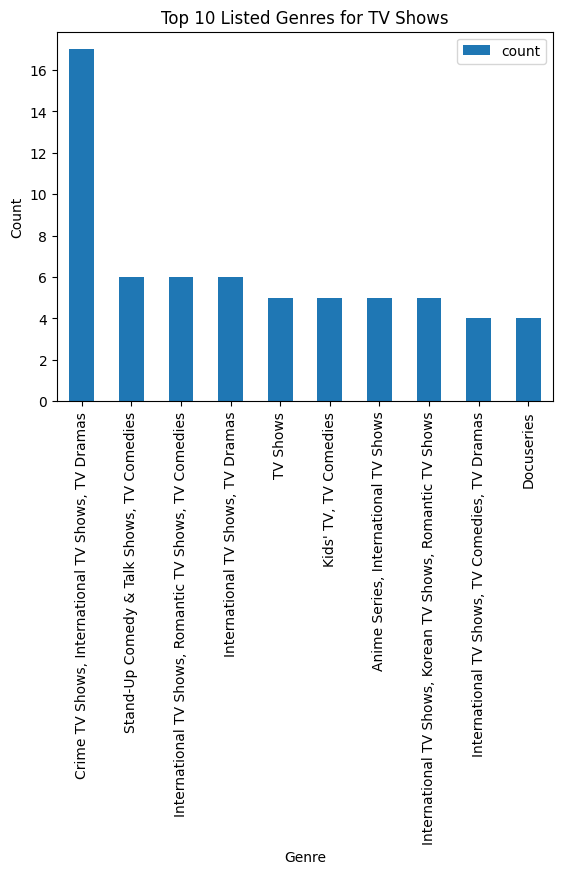

In [ ]:
# visualizing the listed_in column
top_10_listed_in_movie.plot(x='listed_in', y='count', kind='bar')
plt.title('Top 10 Listed Genres for Movies')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()
top_10_listed_in_TV_Show.plot(x='listed_in', y='count', kind='bar')
plt.title('Top 10 Listed Genres for TV Shows')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

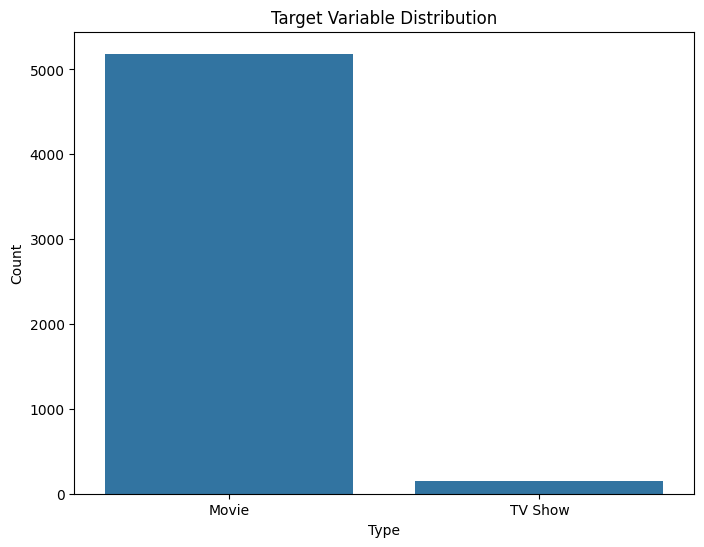

In [ ]:
# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=netflix)
plt.title('Target Variable Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

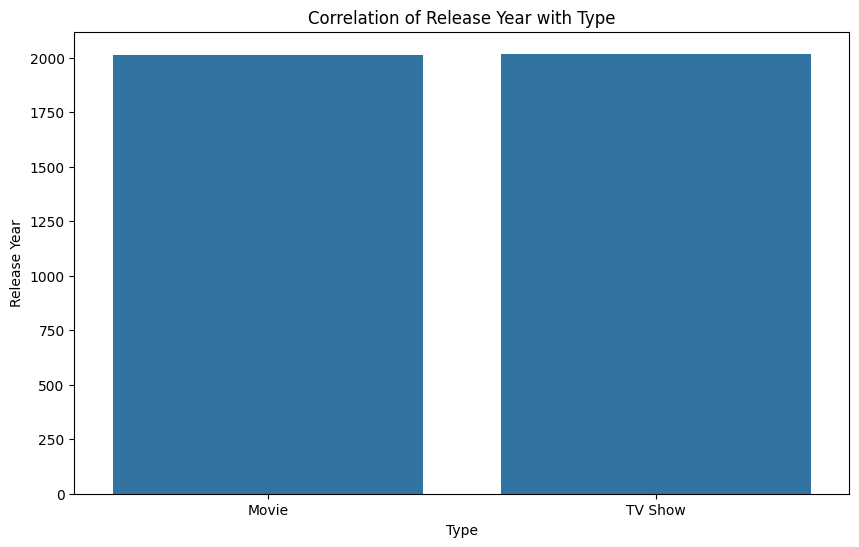

In [ ]:
# Correlation of features with the target variable (Barplot)
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='release_year', data=netflix)
plt.title('Correlation of Release Year with Type')
plt.xlabel('Type')
plt.ylabel('Release Year')
plt.show()

# Separate features and target variable
X = netflix.drop(columns=['type'])  # Features
y = netflix['type']  # Target variable

# Apply oversampling to address class imbalance
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Convert back to DataFrame if needed
netflix_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['type'])], axis=1)

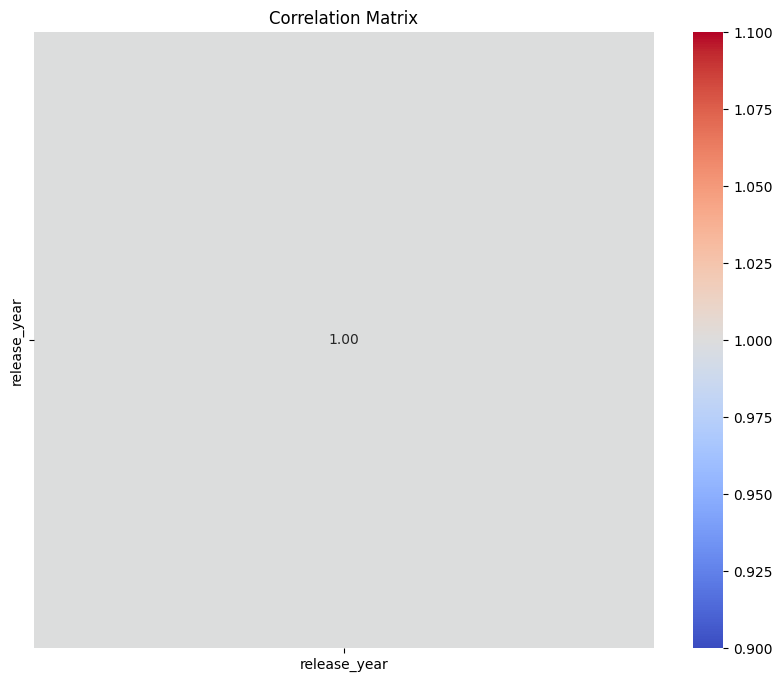


Top 10 Listed Genres for TV Shows:
                                             listed_in     type  count
196  Crime TV Shows, International TV Shows, TV Dramas  TV Show     17
327          Stand-Up Comedy & Talk Shows, TV Comedies  TV Show      6
299  International TV Shows, Romantic TV Shows, TV ...  TV Show      6
306                  International TV Shows, TV Dramas  TV Show      6
333                                           TV Shows  TV Show      5
314                              Kids' TV, TV Comedies  TV Show      5
74                Anime Series, International TV Shows  TV Show      5
293  International TV Shows, Korean TV Shows, Roman...  TV Show      5
305     International TV Shows, TV Comedies, TV Dramas  TV Show      4
225                                         Docuseries  TV Show      4


In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
numeric_columns = netflix.select_dtypes(include=np.number).columns
sns.heatmap(netflix[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
print("\nTop 10 Listed Genres for TV Shows:")
print(top_10_listed_in_TV_Show)

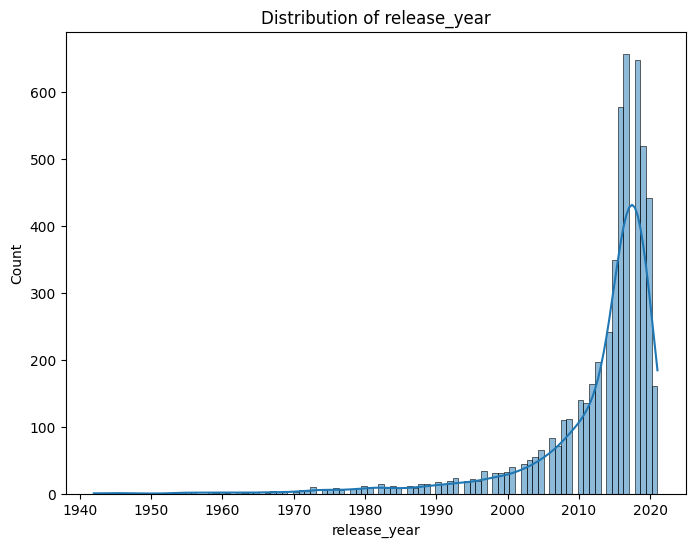

In [ ]:
# Distribution plots of each feature
for column in X.columns:
    if X[column].dtype in ['int64', 'float64']:  # Check if the column is numerical
        plt.figure(figsize=(8, 6))
        sns.histplot(X[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()


In [ ]:
# Assuming X_resampled contains features and y_resampled contains labels
# Assuming X_resampled is a pandas DataFrame

# Encode categorical variables
label_encoder = LabelEncoder()
X_resampled_encoded = X_resampled.apply(label_encoder.fit_transform)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_encoded, y_resampled, test_size=0.2, random_state=42)

# Initializing classifiers
rf_classifier = RandomForestClassifier()
logistic_classifier = LogisticRegression()

# Training the models
rf_classifier.fit(X_train, y_train)
logistic_classifier.fit(X_train, y_train)

# Making predictions
rf_pred = rf_classifier.predict(X_test)
logistic_pred = logistic_classifier.predict(X_test)

# Evaluating RandomForestClassifier
print("RandomForestClassifier Metrics:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))

# Evaluating Logistic Regression
print("\nLogistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, logistic_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, logistic_pred))
print("Classification Report:\n", classification_report(y_test, logistic_pred))

# Model Comparison
# You can compare accuracy, precision, recall, F1-score, etc., to determine the best model for your task.
# Additionally, you can use cross-validation techniques for a more robust evaluation.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier Metrics:
Accuracy: 1.0
Confusion Matrix:
 [[1035    0]
 [   0 1039]]
Classification Report:
               precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1035
     TV Show       1.00      1.00      1.00      1039

    accuracy                           1.00      2074
   macro avg       1.00      1.00      1.00      2074
weighted avg       1.00      1.00      1.00      2074


Logistic Regression Metrics:
Accuracy: 0.682738669238187
Confusion Matrix:
 [[643 392]
 [266 773]]
Classification Report:
               precision    recall  f1-score   support

       Movie       0.71      0.62      0.66      1035
     TV Show       0.66      0.74      0.70      1039

    accuracy                           0.68      2074
   macro avg       0.69      0.68      0.68      2074
weighted avg       0.69      0.68      0.68      2074



In [ ]:
netflix_encoded = netflix.copy()  # Assuming you want to create a copy of the original DataFrame

# Assuming 'date_added' is a datetime column, you might convert it to a timestamp
netflix_encoded['date_added_timestamp'] = pd.to_datetime(netflix_encoded['date_added']).astype(int) / 10**9

# Drop the original datetime column
netflix_encoded.drop(columns=['date_added'], inplace=True)

# Encode categorical variables if needed
netflix_encoded = pd.get_dummies(netflix_encoded)  # Assuming you want to one-hot encode categorical variables

# Now, you can use netflix_encoded in your code

# Check data types
print(netflix_encoded.dtypes)


release_year                                                                                                                                                            int64
date_added_timestamp                                                                                                                                                  float64
show_id_s10                                                                                                                                                              bool
show_id_s1000                                                                                                                                                            bool
show_id_s1002                                                                                                                                                            bool
                                                                                                                                  

In [ ]:
# Check the data types of each column
print(netflix.dtypes)

# Check for non-numeric columns
non_numeric_columns = netflix.select_dtypes(exclude=np.number).columns
print(non_numeric_columns)

# Handle categorical variables: If there are categorical variables, encode them
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X_resampled)

show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
dtype: object
Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


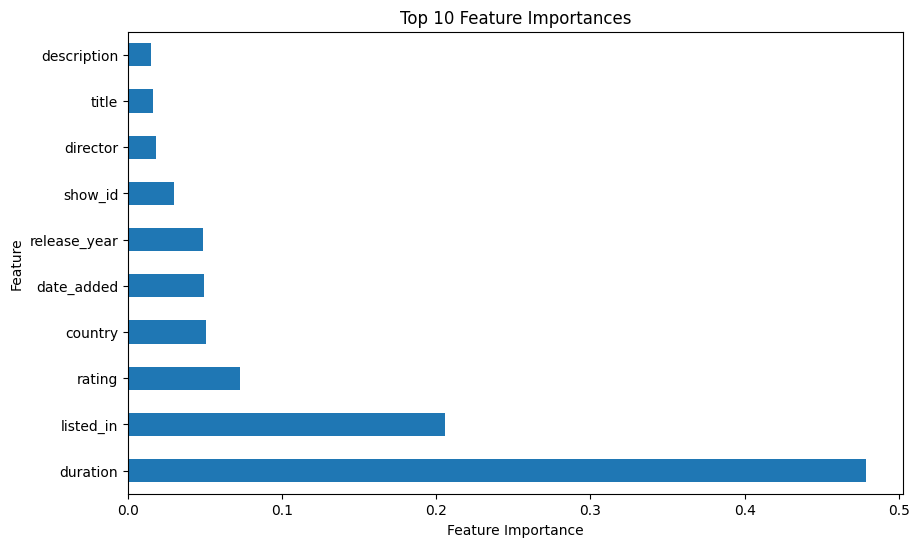

In [ ]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(rf_classifier.feature_importances_, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

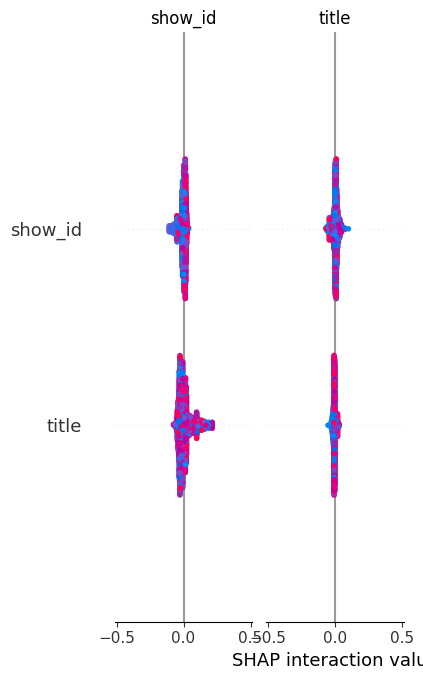

In [ ]:
# Interpretation using SHAP values
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# Separate features and target variable
X = netflix.drop(columns=['type'])  # Features
y = netflix['type']  # Target variable

# Apply oversampling to address class imbalance
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Convert back to DataFrame if needed
netflix_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['type'])], axis=1)

# Encode categorical variables
label_encoder = LabelEncoder()
X_resampled_encoded = X_resampled.apply(label_encoder.fit_transform)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_encoded, y_resampled, test_size=0.2, random_state=42)

# Initializing classifiers
rf_classifier = RandomForestClassifier()
logistic_classifier = LogisticRegression()

# Training the models
rf_classifier.fit(X_train, y_train)
logistic_classifier.fit(X_train, y_train)

# Making predictions
rf_pred = rf_classifier.predict(X_test)
logistic_pred = logistic_classifier.predict(X_test)

# Evaluating RandomForestClassifier
rf_accuracy = accuracy_score(y_test, rf_pred)

# Evaluating Logistic Regression
logistic_accuracy = accuracy_score(y_test, logistic_pred)

# Print the accuracies
print("RandomForestClassifier Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", logistic_accuracy)


RandomForestClassifier Accuracy: 1.0
Logistic Regression Accuracy: 0.6774349083895853


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
